### Imports

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from pprint import pprint

### Preprocessing

In [2]:
def indicators(df: pd.DataFrame):
    close = df["close"]
    high = df["high"]
    low = df["low"]
    volume = df["volume"]

    df["ema12"] = close.ewm(span=12).mean()
    df["ema26"] = close.ewm(span=26).mean()
    df["macd"] = df["ema12"] - df["ema26"]
    df["macd_signal"] = df["macd"].ewm(span=9).mean()

    prev_close = close.shift(1)
    tr = pd.concat([
        high - low,
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)
    atr = tr.rolling(window=14).mean()
    plus_dm = (high - high.shift(1)).clip(lower=0)
    minus_dm = (low.shift(1) - low).clip(lower=0)
    plus_di = 100 * (plus_dm.rolling(14).mean() / atr)
    minus_di = 100 * (minus_dm.rolling(14).mean() / atr)
    dx = 100 * (plus_di - minus_di).abs() / (plus_di + minus_di)
    df["adx"] = dx.rolling(14).mean()

    delta = close.diff()
    gain = delta.clip(lower=0).rolling(14).mean()
    loss = (-delta.clip(upper=0)).rolling(14).mean()
    rs = gain / (loss + 1e-5)
    df["rsi"] = 100 - (100 / (1 + rs))

    ll = low.rolling(14).min()
    hh = high.rolling(14).max()
    k = 100 * ((close - ll) / (hh - ll + 1e-5))
    df["slowk"] = k
    df["slowd"] = k.rolling(3).mean()

    df["roc"] = 100 * (close - close.shift(10)) / close.shift(10)

    ma = close.rolling(20).mean()
    std = close.rolling(20).std()
    upper = ma + 2 * std
    lower = ma - 2 * std
    df["bb_upper"] = upper
    df["bb_middle"] = ma
    df["bb_lower"] = lower
    df["bb_percent_b"] = (close - lower) / (upper - lower + 1e-5)

    df["atr"] = atr

    direction = close.diff().apply(np.sign)
    df["obv"] = (direction * volume).fillna(0).cumsum()

    tp = (high + low + close) / 3
    mf = tp * volume
    pos_mf = mf.where(tp.diff() > 0, 0.0)
    neg_mf = mf.where(tp.diff() < 0, 0.0)
    pos_sum = pos_mf.rolling(14).sum()
    neg_sum = neg_mf.rolling(14).sum()
    mfr = pos_sum / (neg_sum + 1e-5)
    df["mfi"] = 100 - (100 / (1 + mfr))

    df["vwap"] = (tp * volume).cumsum() / volume.cumsum()

    return df.dropna()

def fetch_stock_data(symbols, seq_len=2048, horizon=3):
    def label_direction(pct_change, threshold=1.0):
        if pct_change > threshold:
            return 1  # Buy
        elif pct_change < -threshold:
            return 2  # Sell
        else:
            return 0
    result = {}
    for symbol in symbols:
        df = yf.download(symbol, interval="5m", period="16d", progress=False, auto_adjust=False)

        if isinstance(df.columns, pd.MultiIndex):
            df = df.xs(symbol, axis=1, level=1)

        df = df.rename(columns={
            "Open": "open",
            "High": "high",
            "Low": "low",
            "Close": "close",
            "Volume": "volume",
        })[["open", "high", "low", "close", "volume"]]

        df = indicators(df)

        if len(df) > seq_len + horizon:
            df = df.iloc[-seq_len - horizon:]

        close = df["close"]
        future = close.shift(-horizon)
        pct_change = ((future - close) / close) * 100
        threshold = (df["atr"].mean() / df["close"].mean()) * 100

        # horizon = 3
        # pct_changes = df["close"].pct_change(periods=horizon).abs() * 100
        # threshold = pct_changes.quantile(0.75)  # Use the 75th percentile

        df.loc[:, "label"] = pct_change.apply(lambda x: label_direction(x, threshold))
        df = df.drop(columns=["open", "high", "low"]).dropna()

        numeric = df.drop(columns=["label"])
        normalized = (numeric - numeric.mean()) / (numeric.std() + 1e-6)
        normalized["label"] = df["label"]

        result[symbol] = normalized.reset_index(drop=False)

    return result

class SequenceDataset(Dataset):
    def __init__(self, df: pd.DataFrame, window_size=60):
        numeric_df = df.drop(columns=["label", "Datetime"])
        arr = numeric_df.values
        labels = df["label"].values.astype(int)
        self.X = []
        self.y = []
        for i in range(len(arr) - window_size):
            self.X.append(arr[i:i+window_size])
            self.y.append(labels[i + window_size])
        self.X = torch.tensor(np.stack(self.X), dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
label_map = {0: "Hold", 1: "Buy", 2: "Sell"}

### Architecture

In [3]:
class GRUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, num_classes=3, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.prelu = nn.PReLU()
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.PReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1]
        out = self.prelu(out)
        return self.classifier(out)

def train_model(df, window_size, epochs):
    ds = SequenceDataset(df, window_size=window_size)
    train_loader = DataLoader(ds, batch_size=32, shuffle=True)

    model = GRUClassifier(input_dim=df.shape[1] - 2)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    labels_np = ds.y.numpy()
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels_np), y=labels_np)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    model.train()
    pbar = tqdm(range(epochs), desc="Epochs")
    for epoch in pbar:
        running_loss = 0.0
        for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            optimizer.zero_grad()
            pred = model(X)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)

        if epoch == epochs - 1: pbar.set_postfix(final_loss=f"{avg_loss:.4f}")

    return model

def infer_model(model, df, window_size):
    ds = SequenceDataset(df, window_size=window_size)
    model.eval()
    with torch.no_grad():
        preds = model(ds.X).argmax(dim=1).cpu().numpy()
    return preds, df["close"].values[window_size:]

### Training

In [4]:
window_size = 60
symbols = ["AAPL", "BLK", "GOOGL", "NVDA", "TSLA"]
data = fetch_stock_data(symbols)

results = {}

for symbol in symbols:
    print(f"Processing symbol: {symbol}")
    raw = deepcopy(data[symbol])
    raw["Datetime"] = pd.to_datetime(raw["Datetime"])

    latest_day = raw["Datetime"].dt.date.max()
    train_df = raw[raw["Datetime"].dt.date < latest_day].reset_index(drop=True)

    df = raw.reset_index(drop=True)

    model = train_model(train_df, window_size, epochs=32)

    preds, prices = infer_model(model, df, window_size)
    true_labels = df["label"].values[window_size:]

    dt = df["Datetime"][window_size:].reset_index(drop=True)
    is_latest = dt.dt.date == latest_day

    latest_actions = pd.DataFrame({
        "datetime": dt[is_latest].dt.strftime("%Y-%m-%d %H:%M"),
        "action": [label_map[p] for p in preds[is_latest]]
    })

    results[symbol] = {
        "model": model,
        "predictions": preds,
        "true_labels": true_labels,
        "prices": prices,
        "balanced_accuracy": balanced_accuracy_score(true_labels, preds),
        "classification_report": classification_report(true_labels, preds, output_dict=True),
        "confusion_matrix": confusion_matrix(true_labels, preds),
        "latest_day": latest_day,
        "latest_actions": latest_actions
    }
symbol_iter = iter(symbols)

Processing symbol: AAPL


Epochs:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 2/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 3/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 4/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 5/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 6/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 7/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 8/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 9/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 10/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 11/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 12/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 13/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 14/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 15/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 16/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 17/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 18/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 19/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 20/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 21/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 22/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 23/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 24/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 25/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 26/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 27/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 28/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 29/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 30/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 31/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 32/32:   0%|          | 0/34 [00:00<?, ?it/s]

Processing symbol: BLK


Epochs:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 15/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 16/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 17/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 18/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 19/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 20/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 21/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 22/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 23/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 24/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 25/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 26/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 27/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 28/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 29/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 30/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 31/32:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 32/32:   0%|          | 0/33 [00:00<?, ?it/s]

Processing symbol: GOOGL


Epochs:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 2/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 3/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 4/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 5/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 6/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 7/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 8/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 9/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 10/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 11/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 12/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 13/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 14/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 15/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 16/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 17/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 18/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 19/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 20/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 21/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 22/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 23/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 24/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 25/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 26/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 27/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 28/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 29/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 30/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 31/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 32/32:   0%|          | 0/34 [00:00<?, ?it/s]

Processing symbol: NVDA


Epochs:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 2/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 3/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 4/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 5/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 6/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 7/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 8/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 9/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 10/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 11/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 12/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 13/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 14/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 15/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 16/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 17/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 18/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 19/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 20/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 21/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 22/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 23/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 24/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 25/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 26/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 27/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 28/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 29/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 30/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 31/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 32/32:   0%|          | 0/34 [00:00<?, ?it/s]

Processing symbol: TSLA


Epochs:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 2/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 3/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 4/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 5/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 6/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 7/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 8/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 9/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 10/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 11/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 12/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 13/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 14/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 15/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 16/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 17/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 18/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 19/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 20/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 21/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 22/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 23/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 24/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 25/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 26/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 27/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 28/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 29/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 30/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 31/32:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 32/32:   0%|          | 0/34 [00:00<?, ?it/s]

### Eval

In [5]:
def plot_predictions(prices, preds, symbol):
    times = np.arange(len(prices))

    hold_idx = [i for i, p in enumerate(preds) if p == 0]
    buy_idx = [i for i, p in enumerate(preds) if p == 1]
    sell_idx = [i for i, p in enumerate(preds) if p == 2]

    plt.figure(figsize=(12, 4))
    plt.plot(times, prices, label=f"{symbol} Price", color="black")
    plt.scatter(times[buy_idx], prices[buy_idx], color="green", label="Buy", marker="^")
    plt.scatter(times[sell_idx], prices[sell_idx], color="red", label="Sell", marker="v")
    plt.scatter(times[hold_idx], prices[hold_idx], color="gray", label="Hold", marker="o", alpha=0.5)
    plt.title(f"{symbol} - Model Predictions")
    plt.xlabel("Time (5-min intervals)")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def format_floats(obj):
    if isinstance(obj, dict):
        return {k: format_floats(v) for k, v in obj.items()}
    elif isinstance(obj, float):
        return f"{obj:.4f}"
    else:
        return obj

def plot_confusion_matrix(cm, labels):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Purples", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Normalized Confusion Matrix")
    plt.tight_layout()
    plt.show()

def plot_classification_report(report_dict, title="Classification Report"):
    df = pd.DataFrame(report_dict)
    plt.figure(figsize=(6, 4))
    sns.heatmap(df, annot=True, fmt=".2f", cmap="Blues")
    plt.title(title)
    plt.tight_layout()
    plt.show()

Metrics for AAPL:

Balanced Accuracy: 0.8737


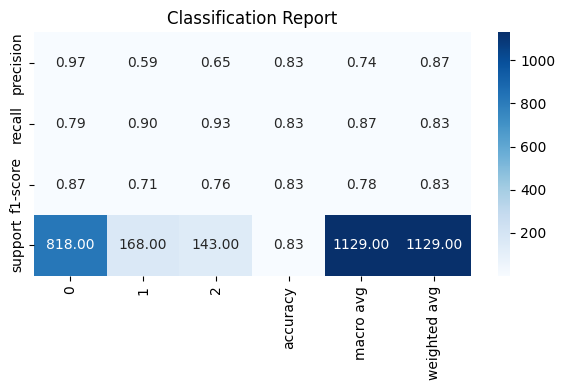

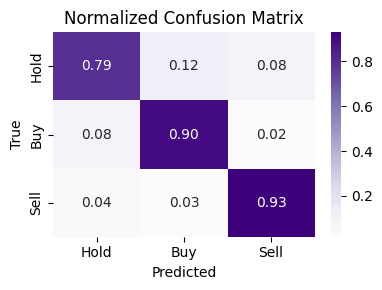


Latest Day: 2025-07-28
Latest Actions:
        datetime action
2025-07-28 13:30   Sell
2025-07-28 13:35   Sell
2025-07-28 13:40   Sell
2025-07-28 13:45   Hold
2025-07-28 13:50   Hold
2025-07-28 13:55   Hold
2025-07-28 14:00    Buy
2025-07-28 14:05   Hold
2025-07-28 14:10   Hold
2025-07-28 14:15   Hold
2025-07-28 14:20   Hold
2025-07-28 14:25   Hold
2025-07-28 14:30   Hold
2025-07-28 14:35   Hold
2025-07-28 14:40   Hold
2025-07-28 14:45   Hold
2025-07-28 14:50   Hold
2025-07-28 14:55   Hold
2025-07-28 15:00   Hold
2025-07-28 15:05    Buy
2025-07-28 15:10    Buy
2025-07-28 15:15    Buy
2025-07-28 15:20   Hold
2025-07-28 15:25   Hold
2025-07-28 15:30   Hold
2025-07-28 15:35   Hold
2025-07-28 15:40   Hold
2025-07-28 15:45   Hold
2025-07-28 15:50   Hold
2025-07-28 15:55   Hold
2025-07-28 16:00   Hold
2025-07-28 16:05   Hold
2025-07-28 16:10   Hold
2025-07-28 16:15   Hold
2025-07-28 16:20   Hold
2025-07-28 16:25   Hold
2025-07-28 16:30   Hold
2025-07-28 16:35   Sell
2025-07-28 16:40   Hold


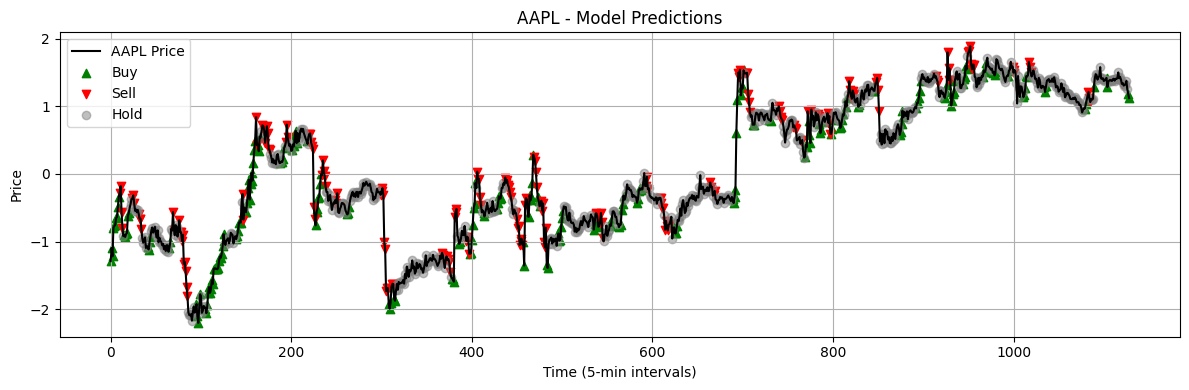

In [6]:
symbol = next(symbol_iter)
print(f"Metrics for {symbol}:\n")

print("Balanced Accuracy:", f"{results[symbol]['balanced_accuracy']:.4f}")

plot_classification_report(results[symbol]["classification_report"])

plot_confusion_matrix(results[symbol]["confusion_matrix"], labels=list(label_map.values()))

ld = results[symbol]["latest_day"]
acts = results[symbol]["latest_actions"]
print(f"\nLatest Day: {ld}")
print("Latest Actions:")
print(acts.to_string(index=False))

plot_predictions(results[symbol]["prices"], results[symbol]["predictions"], symbol)

Metrics for BLK:

Balanced Accuracy: 0.8093


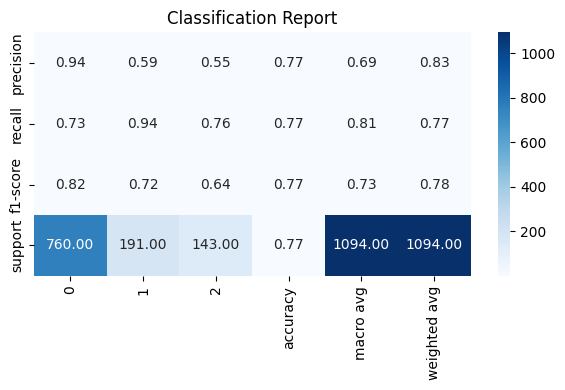

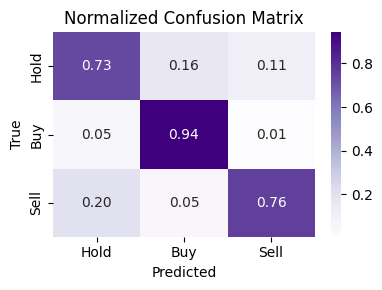


Latest Day: 2025-07-28
Latest Actions:
        datetime action
2025-07-28 13:30   Sell
2025-07-28 13:35   Sell
2025-07-28 13:40   Sell
2025-07-28 13:45   Hold
2025-07-28 13:50   Hold
2025-07-28 13:55   Hold
2025-07-28 14:00    Buy
2025-07-28 14:05    Buy
2025-07-28 14:10    Buy
2025-07-28 14:15   Hold
2025-07-28 14:20   Hold
2025-07-28 14:25   Hold
2025-07-28 14:30   Hold
2025-07-28 14:35    Buy
2025-07-28 14:40    Buy
2025-07-28 14:45    Buy
2025-07-28 14:55    Buy
2025-07-28 15:00   Hold
2025-07-28 15:05   Hold
2025-07-28 15:10   Hold
2025-07-28 15:15   Hold
2025-07-28 15:20   Hold
2025-07-28 15:25   Hold
2025-07-28 15:30   Hold
2025-07-28 15:35   Hold
2025-07-28 15:40   Hold
2025-07-28 15:45   Hold
2025-07-28 15:50   Hold
2025-07-28 16:00   Hold
2025-07-28 16:05   Hold
2025-07-28 16:10   Hold
2025-07-28 16:15   Hold
2025-07-28 16:20   Hold
2025-07-28 16:25   Hold
2025-07-28 16:30   Hold
2025-07-28 16:35   Hold
2025-07-28 16:40   Hold
2025-07-28 16:45   Hold
2025-07-28 16:50   Hold


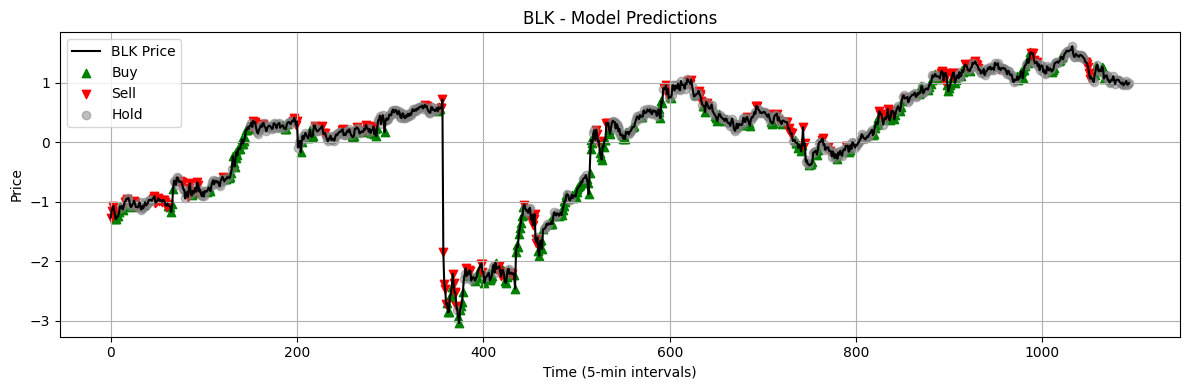

In [7]:
symbol = next(symbol_iter)
print(f"Metrics for {symbol}:\n")

print("Balanced Accuracy:", f"{results[symbol]['balanced_accuracy']:.4f}")

plot_classification_report(results[symbol]["classification_report"])

plot_confusion_matrix(results[symbol]["confusion_matrix"], labels=list(label_map.values()))

ld = results[symbol]["latest_day"]
acts = results[symbol]["latest_actions"]
print(f"\nLatest Day: {ld}")
print("Latest Actions:")
print(acts.to_string(index=False))

plot_predictions(results[symbol]["prices"], results[symbol]["predictions"], symbol)

Metrics for GOOGL:

Balanced Accuracy: 0.8556


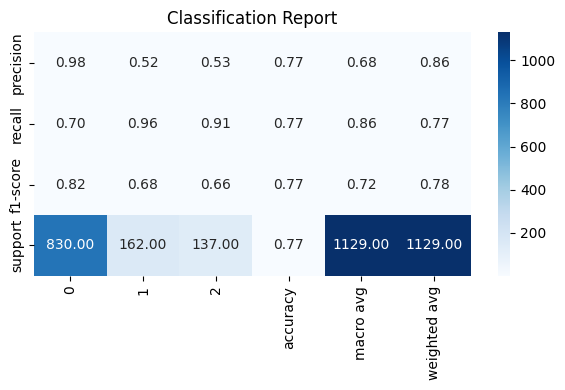

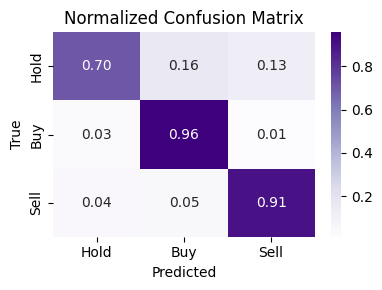


Latest Day: 2025-07-28
Latest Actions:
        datetime action
2025-07-28 13:30   Sell
2025-07-28 13:35   Sell
2025-07-28 13:40   Sell
2025-07-28 13:45   Sell
2025-07-28 13:50    Buy
2025-07-28 13:55    Buy
2025-07-28 14:00    Buy
2025-07-28 14:05    Buy
2025-07-28 14:10    Buy
2025-07-28 14:15   Hold
2025-07-28 14:20   Hold
2025-07-28 14:25   Sell
2025-07-28 14:30   Sell
2025-07-28 14:35   Sell
2025-07-28 14:40   Sell
2025-07-28 14:45   Hold
2025-07-28 14:50    Buy
2025-07-28 14:55   Hold
2025-07-28 15:00   Hold
2025-07-28 15:05   Hold
2025-07-28 15:10   Sell
2025-07-28 15:15   Hold
2025-07-28 15:20   Hold
2025-07-28 15:25    Buy
2025-07-28 15:30   Hold
2025-07-28 15:35   Hold
2025-07-28 15:40   Hold
2025-07-28 15:45   Hold
2025-07-28 15:50   Hold
2025-07-28 15:55   Hold
2025-07-28 16:00   Hold
2025-07-28 16:05   Hold
2025-07-28 16:10   Hold
2025-07-28 16:15   Hold
2025-07-28 16:20   Hold
2025-07-28 16:25   Hold
2025-07-28 16:30   Hold
2025-07-28 16:35   Hold
2025-07-28 16:40   Hold


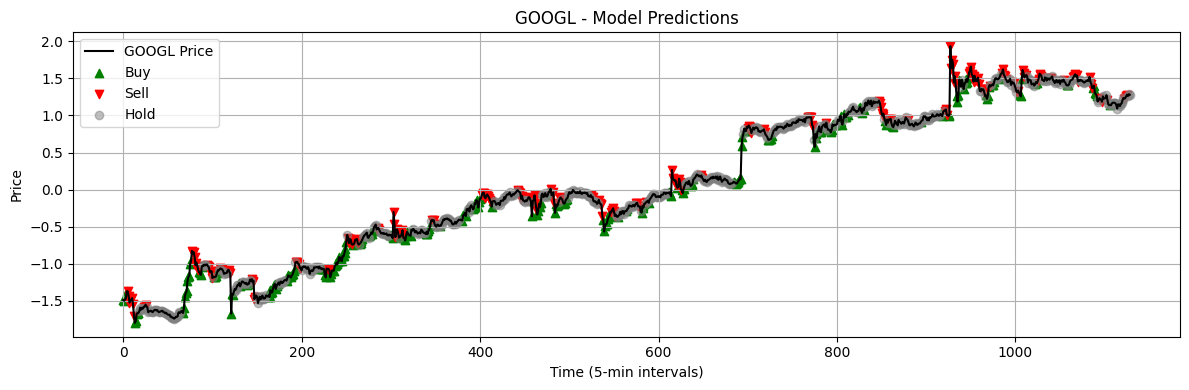

In [8]:
symbol = next(symbol_iter)
print(f"Metrics for {symbol}:\n")

print("Balanced Accuracy:", f"{results[symbol]['balanced_accuracy']:.4f}")

plot_classification_report(results[symbol]["classification_report"])

plot_confusion_matrix(results[symbol]["confusion_matrix"], labels=list(label_map.values()))

ld = results[symbol]["latest_day"]
acts = results[symbol]["latest_actions"]
print(f"\nLatest Day: {ld}")
print("Latest Actions:")
print(acts.to_string(index=False))

plot_predictions(results[symbol]["prices"], results[symbol]["predictions"], symbol)

Metrics for NVDA:

Balanced Accuracy: 0.9192


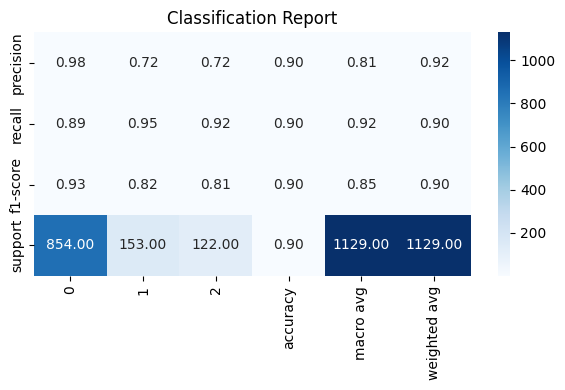

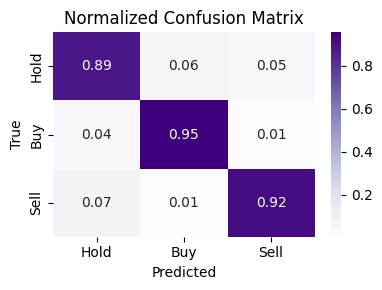


Latest Day: 2025-07-28
Latest Actions:
        datetime action
2025-07-28 13:30    Buy
2025-07-28 13:35    Buy
2025-07-28 13:40   Sell
2025-07-28 13:45   Sell
2025-07-28 13:50   Sell
2025-07-28 13:55   Hold
2025-07-28 14:00   Hold
2025-07-28 14:05   Hold
2025-07-28 14:10   Hold
2025-07-28 14:15   Hold
2025-07-28 14:20    Buy
2025-07-28 14:25    Buy
2025-07-28 14:30   Hold
2025-07-28 14:35   Hold
2025-07-28 14:40   Hold
2025-07-28 14:45   Hold
2025-07-28 14:50   Hold
2025-07-28 14:55   Hold
2025-07-28 15:00   Hold
2025-07-28 15:05   Hold
2025-07-28 15:10   Hold
2025-07-28 15:15   Hold
2025-07-28 15:20   Hold
2025-07-28 15:25   Hold
2025-07-28 15:30   Hold
2025-07-28 15:35   Hold
2025-07-28 15:40   Hold
2025-07-28 15:45   Hold
2025-07-28 15:50   Hold
2025-07-28 15:55   Hold
2025-07-28 16:00   Hold
2025-07-28 16:05   Hold
2025-07-28 16:10   Hold
2025-07-28 16:15   Hold
2025-07-28 16:20   Hold
2025-07-28 16:25   Hold
2025-07-28 16:30   Hold
2025-07-28 16:35   Hold
2025-07-28 16:40   Hold


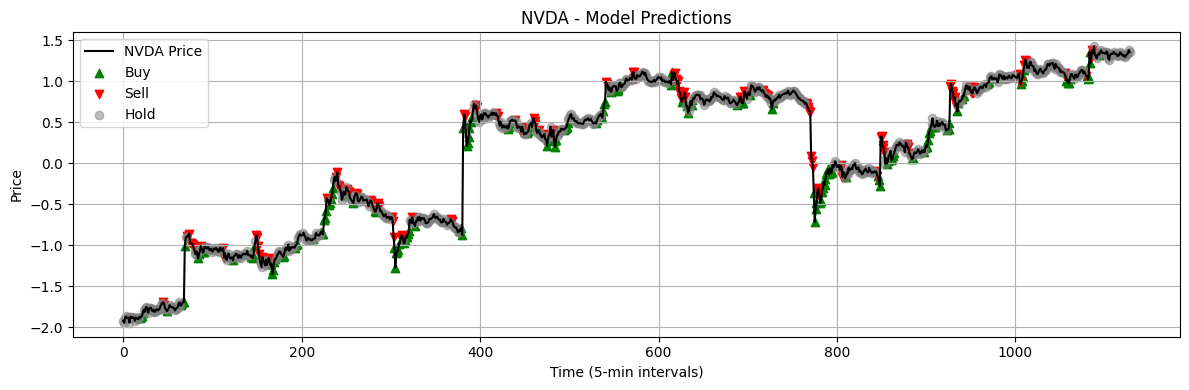

In [9]:
symbol = next(symbol_iter)
print(f"Metrics for {symbol}:\n")

print("Balanced Accuracy:", f"{results[symbol]['balanced_accuracy']:.4f}")

plot_classification_report(results[symbol]["classification_report"])

plot_confusion_matrix(results[symbol]["confusion_matrix"], labels=list(label_map.values()))

ld = results[symbol]["latest_day"]
acts = results[symbol]["latest_actions"]
print(f"\nLatest Day: {ld}")
print("Latest Actions:")
print(acts.to_string(index=False))

plot_predictions(results[symbol]["prices"], results[symbol]["predictions"], symbol)

Metrics for TSLA:

Balanced Accuracy: 0.8684


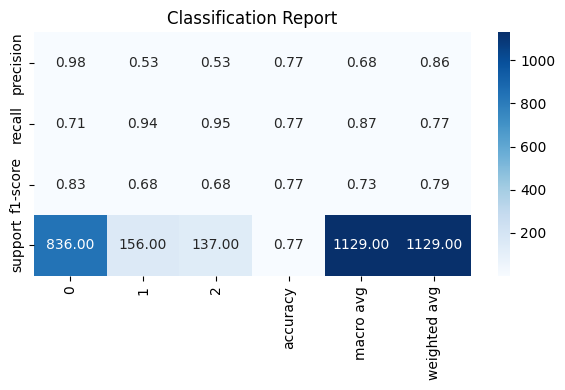

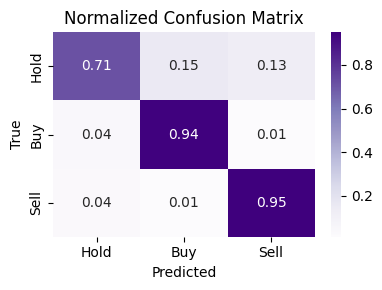


Latest Day: 2025-07-28
Latest Actions:
        datetime action
2025-07-28 13:30    Buy
2025-07-28 13:35    Buy
2025-07-28 13:40    Buy
2025-07-28 13:45    Buy
2025-07-28 13:50   Sell
2025-07-28 13:55   Sell
2025-07-28 14:00   Hold
2025-07-28 14:05   Hold
2025-07-28 14:10   Hold
2025-07-28 14:15   Hold
2025-07-28 14:20   Hold
2025-07-28 14:25   Hold
2025-07-28 14:30   Hold
2025-07-28 14:35   Hold
2025-07-28 14:40   Hold
2025-07-28 14:45    Buy
2025-07-28 14:50    Buy
2025-07-28 14:55    Buy
2025-07-28 15:00   Hold
2025-07-28 15:05   Hold
2025-07-28 15:10   Hold
2025-07-28 15:15   Hold
2025-07-28 15:20   Hold
2025-07-28 15:25   Hold
2025-07-28 15:30   Hold
2025-07-28 15:35   Hold
2025-07-28 15:40   Hold
2025-07-28 15:45   Hold
2025-07-28 15:50   Hold
2025-07-28 15:55   Hold
2025-07-28 16:00    Buy
2025-07-28 16:05    Buy
2025-07-28 16:10    Buy
2025-07-28 16:15    Buy
2025-07-28 16:20    Buy
2025-07-28 16:25    Buy
2025-07-28 16:30    Buy
2025-07-28 16:35   Hold
2025-07-28 16:40   Hold


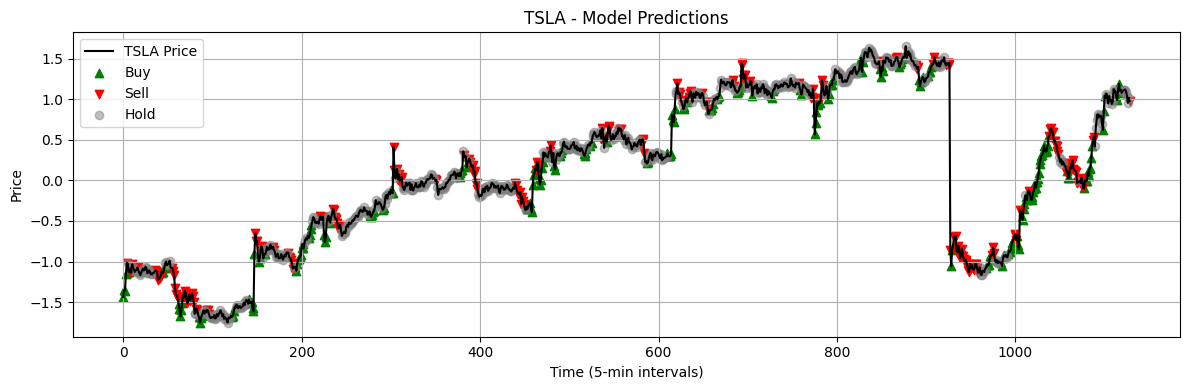

In [10]:
symbol = next(symbol_iter)
print(f"Metrics for {symbol}:\n")

print("Balanced Accuracy:", f"{results[symbol]['balanced_accuracy']:.4f}")

plot_classification_report(results[symbol]["classification_report"])

plot_confusion_matrix(results[symbol]["confusion_matrix"], labels=list(label_map.values()))

ld = results[symbol]["latest_day"]
acts = results[symbol]["latest_actions"]
print(f"\nLatest Day: {ld}")
print("Latest Actions:")
print(acts.to_string(index=False))

plot_predictions(results[symbol]["prices"], results[symbol]["predictions"], symbol)